##Suivi des contacts




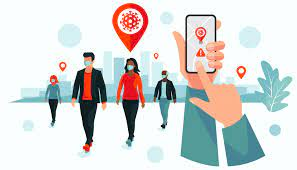




## Introduction
La recherche des contacts est le nom du processus utilisé pour identifier ceux qui entrent en contact avec des personnes qui ont été testées positives pour des maladies contagieuses - telles que la rougeole, le VIH et le COVID-19. Pendant une pandémie, effectuer correctement la recherche des contacts peut aider à réduire le nombre de personnes infectées ou à accélérer le processus de traitement des personnes infectées. Cela peut aider à sauver de nombreuses vies.

Le clustering est une sous-classe d'algorithmes d'apprentissage automatique utilisés pour diviser les données qui partagent certaines caractéristiques dans différents clusters en fonction de ces caractéristiques.


Pour la recherche des contacts, nous devons utiliser un algorithme de clustering basé sur la densité. La raison en est que les maladies sont transférées lorsqu'une personne infectée entre en contact avec d'autres. Ainsi, les zones plus encombrées - denses - auront plus de cas que les moins encombrées.

In [ ]:
pip install pygal


     |████████████████████████████████| 129 kB 8.7 MB/s 


## Importing packages


In [ ]:
import pandas as pd
import pygal
from sklearn.cluster import DBSCAN
import numpy as np
import json

In [ ]:
from IPython.display import display, HTML
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

## Base de données


Pour retracer le mouvement des personnes infectées, les scientifiques utilisent souvent des ensembles de données GPS qui contiennent des informations sur l'heure et l'emplacement d'une personne à une période donnée. Les données de localisation sont souvent représentées sous forme de coordonnées de longitude et de latitude.

Malheureusement, nous ne pouvons pas obtenir de données réelles à partir des emplacements GPS. Nous allons donc créer un ensemble de données simulé sur lequel appliquer notre algorithme. Pnous allons utiliser un générateur de données simulé pour générer un ensemble de données JSON contenant 100 entrées des emplacements de 10 utilisateurs.
cette base de données peut eter télechargere du drive suivant:https://drive.google.com/file/d/1fYkBwXmDHLmRk_MCtiAOrcYwwyIqERbF/view

In [ ]:
dataFrame = pd.read_json(r"/content/MOCK_DATA.json")
dataFrame.head()

,User,TimeStamp,Longitude,Latitude
0,Arthur,2020-08-27 17:33:33,60.077519,13.988041
1,Walter,2020-08-27 20:13:18,60.029391,13.903152
2,Arthur,2020-08-27 18:22:23,60.078368,13.933152
3,Walter,2020-08-27 03:38:36,60.002145,13.967506
4,James,2020-08-27 01:11:35,60.040521,13.966431


In [ ]:
dataFrame.shape

(100, 4)

In [ ]:
dataFrame.describe()

,Longitude,Latitude
count,100.000000,100.000000
mean,60.045713,13.950632
std,0.030070,0.028372
min,60.000345,13.903126
25%,60.021655,13.926333
50%,60.044909,13.948527
75%,60.068417,13.972984
max,60.099804,13.998888


## Visualisation

Pour mieux comprendre les données, nous allons les tracer à l'aide du nuage de points de Pygal. Nous pouvons extraire les différents emplacements de chaque utilisateur et les stocker dans un dictionnaire, puis utiliser ce dictionnaire pour tracer les données.

In [ ]:
disp_dict = {}
for index, row in dataFrame.iterrows():
    if row['User'] not in disp_dict.keys():
        disp_dict[row['User']] = [(row['Latitude'], row['Longitude'])]
    else:
        disp_dict[row['User']].append((row['Latitude'], row['Longitude']))
xy_chart = pygal.XY(stroke=False)
[xy_chart.add(k,v) for k,v in sorted(disp_dict.items())]
display(HTML(base_html.format(rendered_chart=xy_chart.render(is_unicode=True))))



## appliquez l'algorithme DBSCAN

L' algorithme DBSCAN considère les clusters comme des zones de haute densité séparées par des régions de faible densité. Pour cette raison, les clusters trouvés par DBSCAN peuvent être de n'importe quelle forme, par opposition aux k-means, qui suppose que tous les clusters sont de forme convexe.


    eps: ce facteur indique la distance entre les différents points d'un même cluster. Dans notre cas, nous utiliserons la distance recommandée par le CDC, qui est de 6 pieds (ou 0,0018288 kilomètres).
    min_samples: le nombre minimum d'échantillons dans le cluster. Dans le cas de grands ensembles de données bruyants, augmentez ce nombre.
    metric: Ceci définit la métrique de distance entre les points de données. Sklearn a de nombreuses mesures de distance, telles que euclidienne, Manhattan et Minkowski. Pour notre cas, cependant, nous avons besoin d'une mesure de distance qui décrit la distance sur un chiffre (la Terre). La métrique pour cela s'appelle haversine.


In [ ]:
import numpy as np

In [ ]:
safe_distance = 0.0018288 # a radial distance of 6 feet in kilometers
model = DBSCAN(eps=safe_distance, min_samples=2, metric='haversine').fit(dataFrame[['Latitude', 'Longitude']])
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True
labels = model.labels_
dataFrame['Cluster'] = model.labels_.tolist()

In [ ]:
disp_dict_clust = {}
for index, row in dataFrame.iterrows():
    if row['Cluster'] not in disp_dict_clust.keys():
        disp_dict_clust[row['Cluster']] = [(row['Latitude'], row['Longitude'])]
    else:
        disp_dict_clust[row['Cluster']].append((row['Latitude'], row['Longitude']))
print(len(disp_dict_clust.keys()))
from pygal.style import LightenStyle
dark_lighten_style = LightenStyle('#F35548')
xy_chart = pygal.XY(stroke=False, style=dark_lighten_style)
[xy_chart.add(str(k),v) for k,v in disp_dict_clust.items()]
display(HTML(base_html.format(rendered_chart=xy_chart.render(is_unicode=True))))

18


##prédire les personnes infectées

Si nous avons le nom d'une personne infectée, nous pouvons l'utiliser pour obtenir tous les clusters dont cette personne fait partie. De là, nous pouvons voir d'autres personnes dans ces clusters. Ces personnes auront une probabilité plus élevée d'être infectées que celles qui ne le sont pas.


Obtenir tous les clusters auxquels appartient une personne spécifique


In [ ]:
inputName = "William"
inputNameClusters = set()
for i in range(len(dataFrame)):
  if dataFrame['User'][i] == inputName:
    inputNameClusters.add(dataFrame['Cluster'][i])


In [ ]:
inputNameClusters


{-1, 2, 4, 5}

Attirez des personnes dans un cluster spécifique

In [ ]:
infected = set()
for cluster in inputNameClusters:
  if cluster != -1:
    namesInCluster = dataFrame.loc[dataFrame['Cluster'] == cluster, 'User']
    for i in range(len(namesInCluster)):
      name = namesInCluster.iloc[i]
      if name != inputName:
        infected.add(name)


In [ ]:
infected

{'Doreen', 'James', 'John'}

{'Doreen', 'James', 'John'}, ces trois personnes sont potentiellement infectées parce qu'elles sont entrées en contact avec William à un moment et à un endroit.